In [1]:
from utils import *

In [2]:
test_values = []
TEST_PARAMS = {'batch_size':1,
               'images_path':'dataset',
               'shuffle':False,
               'test_values':test_values}

In [3]:
# load dataset
print('Reading dataset from serialized file...')
with open('dataset/partition.p', 'rb') as partition_file:
    IDs, labels = pk.load(partition_file)
print('Loaded. Number of test examples: %d', len(IDs))

Reading dataset from serialized file...
Loaded. Number of test examples: %d 20


In [4]:
print(IDs)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [43]:
print(labels)

{'0': [0, 1, 2, 3, 0, 2, 0], '1': [-1, 3, -1, 1, 1, 0, 0], '2': [1, 0, 2, 0, 2, 0, 0], '3': [0, 0, 0, 0, 0, 0, 0], '4': [-1, 3, -1, 0, 0, 1, 0], '5': [0, 1, 2, 3, 0, 1, 0], '6': [1, 1, 2, 1, 0, 0, 0], '7': [1, 1, 1, 1, 0, 0, 0], '8': [1, 1, 3, 0, 0, 0, 0], '9': [1, 1, 2, 0, 1, 0, 0], '10': [-1, 3, -1, 0, 0, 1, 0], '11': [0, 1, 1, 2, 1, 0, 0], '12': [0, 0, 2, 0, 3, 2, 0], '13': [-1, 3, -1, 1, 0, 1, 0], '14': [0, 0, 3, 0, 0, 0, 0], '15': [0, 2, 2, 3, 3, 2, 0], '16': [1, 2, 1, 0, 1, 1, 0], '17': [0, 1, 1, 1, 0, 1, 0], '18': [-1, 3, -1, 0, 0, 1, 0], '19': [0, 2, 2, 0, 3, 3, 0]}


In [35]:
import zlib
def get_pixelmap(key):
    path = TEST_PARAMS['images_path']
    with open(path+'/event'+key+'.gz', 'rb') as image_file:
        pixels = np.fromstring(zlib.decompress(image_file.read()), dtype=np.uint8, sep='').reshape(3, 500, 500)
        return pixels

In [165]:
import matplotlib.pylab as plt
flav_keys=['numucc', 'nuecc', 'nutaucc', 'NC']
def draw_single_pm(pm, pred=None, flav_label=None, flav_pred=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.suptitle('Pixel Maps')        
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = np.swapaxes(pm[i], 0, 1)
        axs[i].imshow(maps, interpolation='none', cmap='cool')
        axs[i].set_xlabel('Wire')
        axs[i].set_ylabel('TDC')
        axs[i].title.set_text(titles[i])
    plt.show()

In [166]:
def convert_pm(pm):
    views = len(pm)
    planes = pm.shape[1]
    cells = pm.shape[2]
    
    X = [None]*views
    for view in range(views):
        X[view] = np.empty((1, planes, cells, 1), dtype='float32')
    for view in range(views):
        X[view][0, :, :, :] = pm[view, :, :].reshape(planes, cells, 1)
    return X

In [160]:
def get_model(print_model=False): 
    with open('saved_model/model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights('saved_model/weights.h5')

    if(print_model):
        model.summary()
    return model

In [161]:
model = get_model()

In [167]:
ID = '2'

/Users/nitishnayak/for_alissa/cvn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


CVN score : 0.956842, True Label : numucc, Pred Label : numucc


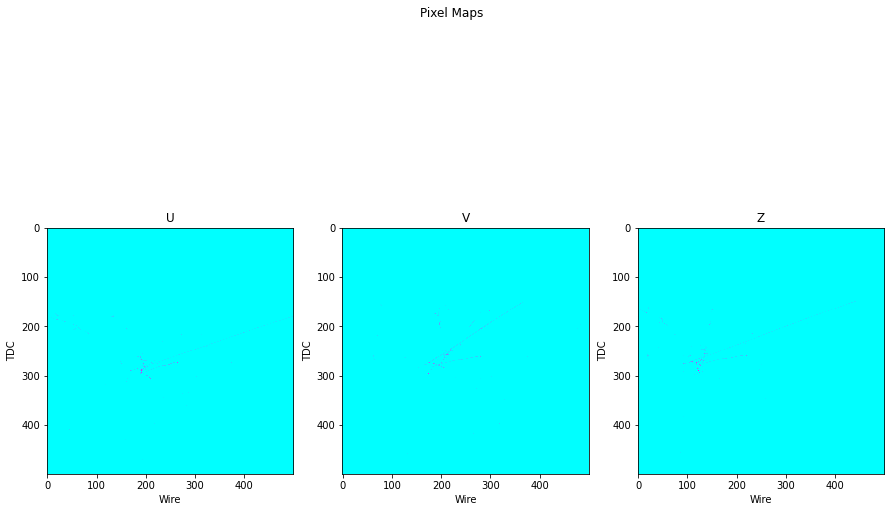

In [168]:
pm = get_pixelmap(ID)
scores = model.predict(convert_pm(pm))
flav_score = np.max(scores[1], axis=1)
flav_pred = np.argmax(scores[1], axis=1)
print('CVN score : %f, True Label : %s, Pred Label : %s'%
      (flav_score[0], flav_keys[labels[ID][1]], flav_keys[flav_pred[0]]))
draw_single_pm(pm)

CVN score : 0.957491, True Label : numucc, Pred Label : numucc


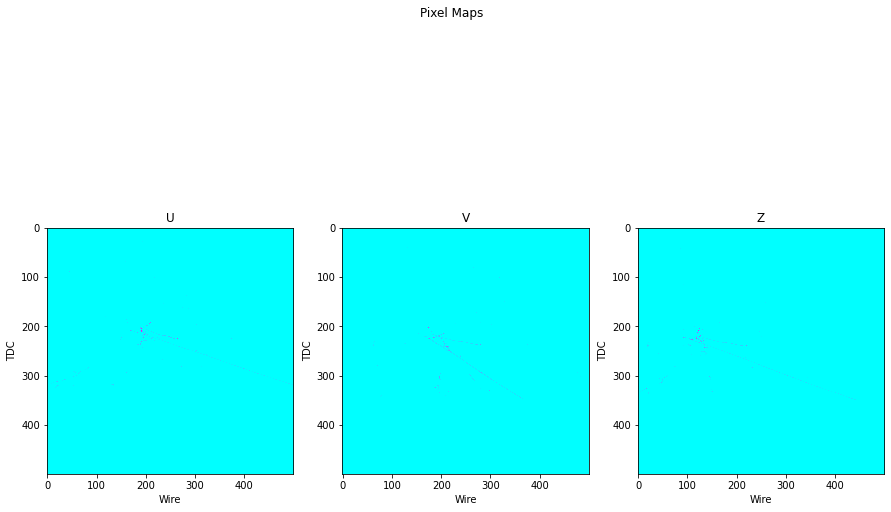

In [169]:
pm2 = np.empty(pm.shape, dtype='float32')
for view in range(3):
    pm2[view] = np.flip(pm[view], axis=1)
scores2 = model.predict(convert_pm(pm2))
flav_score2 = np.max(scores2[1], axis=1)
flav_pred2 = np.argmax(scores2[1], axis=1)
print('CVN score : %f, True Label : %s, Pred Label : %s'%
      (flav_score2[0], flav_keys[labels[ID][1]], flav_keys[flav_pred2[0]]))
draw_single_pm(pm2)